In [1]:
# !pip install lava-nc
# !pip install networkx==2.8
# !pip install matplotlib
# !pip install cvxpy
# !pip install lava-nc
# !pip install pandas

In [2]:
# import lava
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cProfile

In [3]:
def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_array(mat['M'])
    return G

In [8]:
def gen_permutation_matrix(phi):
    n = phi.shape[0]
    order = np.argsort(phi)
    P = np.zeros((n, n))
    for i in range(n):
        P[i,order[i]] = 1  # orignally P[i,order[i]] = 1
    return P, order

def get_chr(P, A, order):
    n = A.shape[0]
    PAPT = (P @ A) @ P.T
    # save as xslx file
    # np.savetxt('PAPT.csv', PAPT, delimiter=',', fmt='%i')
    block_list = []
    color_blocks = []
    i = 0
    while (i<n):
        condition = 0
        block = 0
        color_block = []
        while (condition==0 and (i+block)<n):
            #if PAPT[i:i+block+1,i:i+block+1] == np.zeros((block+1,block+1)):
            if np.sum(np.abs(PAPT[i:i+block+1,i:i+block+1])) == 0:
                color_block.append(order[i+block])
                block = block+1
            else:
                condition = 1
        block_list.append(block)
        color_blocks.append(color_block)
        i = i + block
    return len(block_list), color_blocks

def get_color_indice_array(color_blocks, adj):
    color_indice_array = np.zeros(adj.shape[0], dtype=np.int32)
    temp_color_index = 0
    for color_block in color_blocks:
        for node in color_block:
            color_indice_array[node] = temp_color_index
        temp_color_index += 1
    num_colors = temp_color_index
    return color_indice_array, num_colors

def density(adj_matrix):
    return np.sum(adj_matrix) / (adj_matrix.shape[0] * (adj_matrix.shape[1]-1))

def get_color_adj_graph(color_indice_array, adj, num_colors):
    color_adj = np.zeros((num_colors,num_colors), dtype=np.int32)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if adj[i][j] == 1:
                color_adj[color_indice_array[i]][color_indice_array[j]] = 1
    return color_adj

def loss(phi_history,adj):
    num_nodes = adj.shape[0]
    loss_list = []
    for i in range (len(phi_history)):
        curr_phi = phi_history[i]
        loss = 0
        for j in range (num_nodes):
            for k in range (j):
                if(adj[j][k] == 1):
                    loss -= 1 - np.cos(curr_phi[j] - curr_phi[k])
        loss_list.append(loss)
    return loss_list

def gen_cyclic_graph(n):
    B = np.zeros((n, n))
    for i in range(n):
        B[i,i-1] = 1.0
        B[i,(i+1)%n] = 1.0
    return B

In [9]:

def graph_painter2(adj, num_iters = 3, sigma_noise = 0, phi_init = None, step_size = 0.1):
    # phi is a row vector
    n = adj.shape[0]
    # phi = uniform randomly between -1 and 1
    if phi_init is None:
        curr_phi = np.random.uniform(-1, 1, n)*np.pi*0.5
    else:
        curr_phi = phi_init
    min_colors = n
    best_coloring = [[i] for i in range(n)]
    phi_history = []
    phi_history.append(curr_phi)
    for i in range(num_iters):
        # update phi
        curr_phi = curr_phi + sigma_noise*np.random.randn(n)
        curr_cos = np.cos(curr_phi)
        curr_sin = np.sin(curr_phi)

        curr_cos = np.tile(curr_cos, (n, 1))
        curr_sin = np.tile(curr_sin, (n, 1))
        # Bcos_phi = element-wise multiplication of adj and curr_cos
        Bcos_phi = np.multiply(adj, curr_cos)
        # Bsin_phi = element-wise multiplication of adj and curr_sin
        Bsin_phi = np.multiply(adj, curr_sin)
        cos_phi_transpose = np.transpose(curr_cos)
        sin_phi_transpose = np.transpose(curr_sin)
        # sum the whole row
        cost_term = np.sum(np.multiply(Bcos_phi, sin_phi_transpose) - np.multiply(Bsin_phi, cos_phi_transpose), axis = 1)
        # update phi
        curr_phi = curr_phi + step_size*cost_term
        curr_phi[curr_phi > np.pi] = curr_phi[curr_phi > np.pi] - 2*np.pi
        curr_phi[curr_phi < -np.pi] = curr_phi[curr_phi < -np.pi] + 2*np.pi
        phi_history.append(curr_phi)
        P, order = gen_permutation_matrix(curr_phi)
        num_chr, color_blocks = get_chr(P, adj, order)
        if num_chr < min_colors:
            min_colors = num_chr
            best_coloring = color_blocks
        # convert phi_history to numpy array
    phi_history = np.array(phi_history)
    return min_colors, best_coloring, phi_history

Density of the original graph:  0.7
Density of the colored graph:  1.0
Num Colors:  3
[[0], [4, 2, 3], [1]]


/tmp/ipykernel_4270/4037160581.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4270/4037160581.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4270/4037160581.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


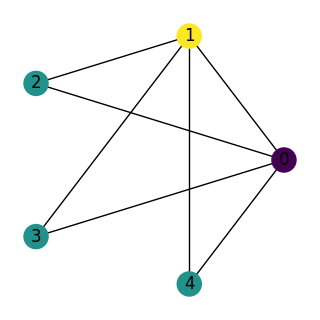

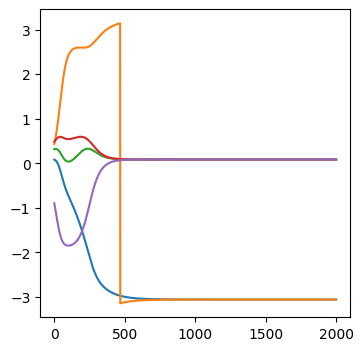

(2001, 5)


In [10]:
# read myciel4 graph
# G = mat_to_graph('test_graphs/dsjc125.5.mat')
# G = complete graph with 3 nodes

n = 3
# craete a complete graph
G = nx.complete_graph(n)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
# add a new node
G.add_node(n)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n)
    G.add_edge(n, i)
    adj[i][n] = 1
    adj[n][i] = 1

G.add_node(n+1)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n+1)
    G.add_edge(n+1, i)
    adj[i][n+1] = 1
    adj[n+1][i] = 1
# print(adj)

# G.add_node(n+2)
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
# for i in range(n-1):
#     G.add_edge(i, n+2)
#     G.add_edge(n+2, i)
#     adj[i][n+2] = 1
#     adj[n+2][i] = 1

density_original = density(adj)
print("Density of the original graph: ", density_original)
num_colors, coloring, phi_history = graph_painter2(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
color_indice_array, _ = get_color_indice_array(coloring, adj)
density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
print("Density of the colored graph: ", density_colored)
print("Num Colors: ", num_colors)
print(coloring)

# Plot the graph with the coloring
plt.figure(figsize=(3, 3))
nx.draw_circular(G, with_labels=True, node_color=color_indice_array)
plt.show()

# plot the phi history row wise
plt.figure(figsize=(4,4))
plt.plot(phi_history)
# plt.legend([i for i in range(adj.shape[0])])
plt.show()

print(phi_history.shape)

In [11]:

def graph_painter2_scaled(adj, num_iters = 3, sigma_noise = 0, phi_init = None, step_size = 0.1):
    # phi is a row vector
    n = adj.shape[0]
    # phi = uniform randomly between -1 and 1
    if phi_init is None:
        curr_phi = np.random.uniform(-1, 1, n)*np.pi*0.5
    else:
        curr_phi = phi_init
    min_colors = n
    best_coloring = [[i] for i in range(n)]
    color_count = np.ones(n)
    phi_history = []
    phi_history.append(curr_phi)
    for i in range(num_iters):
        # update phi
        curr_phi = curr_phi + sigma_noise*np.random.randn(n)
        curr_cos = np.cos(curr_phi)/color_count
        curr_sin = np.sin(curr_phi)/color_count

        curr_cos = np.tile(curr_cos, (n, 1))
        curr_sin = np.tile(curr_sin, (n, 1))
        # Bcos_phi = element-wise multiplication of adj and curr_cos
        Bcos_phi = np.multiply(adj, curr_cos)
        # Bsin_phi = element-wise multiplication of adj and curr_sin
        Bsin_phi = np.multiply(adj, curr_sin)
        cos_phi_transpose = np.transpose(curr_cos)
        sin_phi_transpose = np.transpose(curr_sin)
        # sum the whole row
        cost_term = np.sum(np.multiply(Bcos_phi, sin_phi_transpose) - np.multiply(Bsin_phi, cos_phi_transpose), axis = 1)
        # update phi
        curr_phi = curr_phi + step_size*cost_term
        curr_phi[curr_phi > np.pi] = curr_phi[curr_phi > np.pi] - 2*np.pi
        curr_phi[curr_phi < -np.pi] = curr_phi[curr_phi < -np.pi] + 2*np.pi
        phi_history.append(curr_phi)
        P, order = gen_permutation_matrix(curr_phi)
        num_chr, color_blocks = get_chr(P, adj, order)
        for color_block in color_blocks:
            for node in color_block:
                color_count[node] = len(color_block)
        if num_chr < min_colors:
            min_colors = num_chr
            best_coloring = color_blocks
        # convert phi_history to numpy array
    phi_history = np.array(phi_history)
    return min_colors, best_coloring, phi_history

/tmp/ipykernel_4270/1744522643.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Density of the original graph:  0.11764705882352941
[1.13484867 0.12270287 1.11293103 0.08515443 1.0615319  0.03561637
 1.01383001 0.         0.99556276 0.00509012 1.0161971  0.02736855
 1.05795912 0.07880187 1.09762035 0.11400649 1.12593474 0.1380492 ]
Density of the colored graph:  1.0
Num Colors:  2
[[7, 9, 5, 11, 15, 17, 13, 3, 1], [8, 6, 10, 16, 4, 14, 12, 0, 2]]


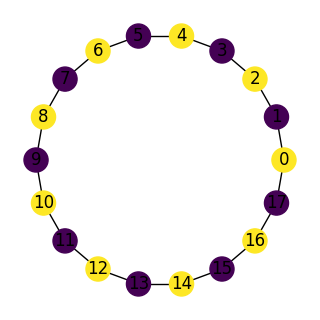

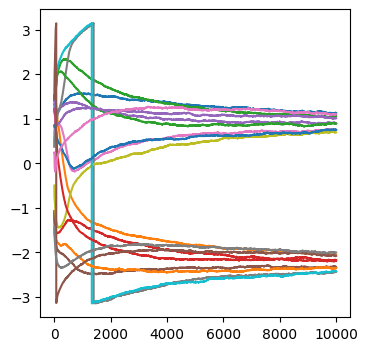

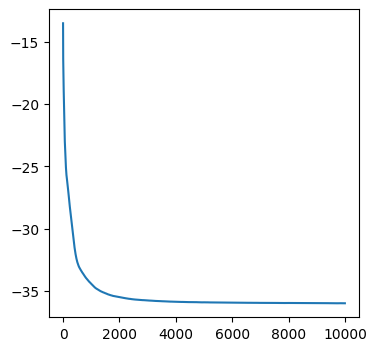

Loss at the end:  -35.97257041095079


In [100]:
# read myciel4 graph
# G = mat_to_graph('test_graphs/queen66.mat')
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
# G = complete graph with 3 nodes

n = 18
# craete a complete graph
adj = gen_cyclic_graph(n)
G = nx.from_numpy_array(adj)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
# add a new node
# G.add_node(n)
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
# for i in range(n-1):
#     G.add_edge(i, n)
#     G.add_edge(n, i)
#     adj[i][n] = 1
#     adj[n][i] = 1

# G.add_node(n+1)
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
# for i in range(n-1):
#     G.add_edge(i, n+1)
#     G.add_edge(n+1, i)
#     adj[i][n+1] = 1
#     adj[n+1][i] = 1
# print(adj)

# G.add_node(n+2)
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
# for i in range(n-1):
#     G.add_edge(i, n+2)
#     G.add_edge(n+2, i)
#     adj[i][n+2] = 1
#     adj[n+2][i] = 1

density_original = density(adj)
print("Density of the original graph: ", density_original)
num_colors, coloring, phi_history = graph_painter2_scaled(adj, num_iters = 10000, sigma_noise = 0.001, step_size = 0.1)
phi_end = phi_history[-1]
print((phi_end-np.min(phi_end))/np.pi)
color_indice_array, _ = get_color_indice_array(coloring, adj)
density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
print("Density of the colored graph: ", density_colored)
print("Num Colors: ", num_colors)
print(coloring)

# Plot the graph with the coloring and phi history row wise
plt.figure(figsize=(3, 3))
nx.draw_circular(G, with_labels=True, node_color=color_indice_array)
plt.show()

plt.figure(figsize=(4,4))
plt.plot(phi_history)
# plt.legend([i for i in range(adj.shape[0])])
plt.show()


loss_list = loss(phi_history, adj)
plt.figure(figsize=(4,4))
plt.plot(loss_list)
plt.show()

print("Loss at the end: ", loss_list[-1])

In [55]:
from GraphColoringTest import gen_permutation_matrix, get_chr, compute_loss, gen_cyclic_graph
import GraphColoringSoln as GC
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor

# define a function graph_painter, input would be a adjacency matrix, output should be a 1-d array of colors

def graph_painter_basic(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01):
    # adj is a numpy array
    B = adj
    num_nodes = B.shape[0]
    conns = np.sum(B, axis=1)
    # Cscale = 0.1
    Cscale = 0.1
    C = (1.0 - adj)
    connsC = np.sum(C, axis=1)
    num_steps = num_iters
    sigma = sigma_noise
    init_range = 0.7*np.pi
    phi_init = np.random.uniform(-init_range, init_range, size=(num_nodes,))
    # phi_init = np.asarray([0,2*np.pi/3,4*np.pi/3,0])
    # phi_init = np.asarray([0,np.pi/2,3*np.pi/2, 2*np.pi/2])-np.pi
    # initialize in multiples of 2*pi/ number of nodes starting from -pi
    # phi_init = np.linspace(-np.pi, np.pi, num_nodes, endpoint=False) + 0.1*np.random.randn(num_nodes)
    # phi_init = np.linspace(-np.pi, np.pi, num_nodes, endpoint=False) 
    # phi_init = [0, 2*np.pi/3, -2*np.pi/3 , 0, 2*np.pi/3]
    # phi_init = np.asarray(phi_init)-np.pi

    cos_phi_init = np.cos(phi_init)
    sin_phi_init = np.sin(phi_init)

    lr = step_size

    lrc = lr*(num_nodes - conns)/(num_nodes)
    lrr = Cscale*lr*conns/(num_nodes)
    tau = 500
    decay = 1 - 1/tau

    # nodes = GC.OScillatoryNeuron(shape=(num_nodes,), phi=phi_init, sigma=sigma, decay=decay, lrc=lrc, lrr=lrr)
    # connections = GC.GraphColorUpdate(shape=(num_nodes,), shape_mat=(num_nodes, num_nodes), B=B, C=C)

    nodes = GC.OScillatoryNeuronBasic(shape=(num_nodes,), phi=phi_init, sigma=sigma, decay=decay, lrc=lrc)
    connections = GC.GraphColorUpdateBasic(shape=(num_nodes,), shape_mat=(num_nodes, num_nodes), B=B)
    phi_monitor = Monitor()

    nodes.cos_out.connect(connections.cos_in)
    nodes.sin_out.connect(connections.sin_in)

    connections.B_cos_out.connect(nodes.B_cos_in)
    connections.B_sin_out.connect(nodes.B_sin_in)
    # connections.C_cos_out.connect(nodes.C_cos_in)
    # connections.C_sin_out.connect(nodes.C_sin_in)
    phi_monitor.probe(nodes.phi, num_steps)
    
    nodes.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi1SimCfg())
    phi_vals = phi_monitor.get_data()
    nodes.stop()
    # print(list(phi_vals.keys()))
    phi_history = phi_vals[list(phi_vals.keys())[0]]['phi']
    # phi_history = phi_vals['Process_0']['phi']

    last_phi = phi_history[-1,:]
    P, order = gen_permutation_matrix(last_phi)
    # chromatic_number, min_color_blocks = get_chr(P, adj, order)
    # print("order-based chromatic number at simulation end: ", chromatic_number)
    # print("color blocks at simulation end: ", min_color_blocks)
    
    print_fr = 500
    chr_ns = []
    min_chr_n = num_nodes
    min_ind = 0
    min_chr_n_color_blocks = [[i] for i in range(num_nodes)]
    for i in range(phi_history.shape[0]):
        # if i%print_fr == print_fr-1:
        #     print("computing for iter: ", i+1)
        #     print("minimum chromatic number: ", min_chr_n)
        curr_phi = phi_history[i,:]
        P, order = gen_permutation_matrix(curr_phi)
        chr_n, chr_n_color_blocks = get_chr(P, adj, order)  # changes here
        if chr_n<min_chr_n:
            min_chr_n = chr_n
            min_ind = i
            min_chr_n_color_blocks = chr_n_color_blocks
        chr_ns.append(chr_n)
    
    # print("minimum order-based chromatic number during simulation: ", min_chr_n)
    # print("color blocks at minimum chromatic number: ", min_chr_n_color_blocks)

    return min_chr_n_color_blocks, phi_history, curr_phi

Density of the original graph:  0.11764705882352941


/tmp/ipykernel_4270/3756841701.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


[1.55972147 0.66766119 1.77689887 0.88766316 0.         1.11376519
 0.22864003 1.34416905 0.45981562 1.57502852 0.68931039 1.80227898
 0.91371309 0.02357793 1.13202732 0.23938354 1.34609791 0.45269716]
Density of the colored graph:  1.0
Num Colors:  3


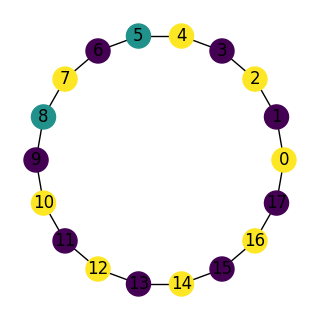

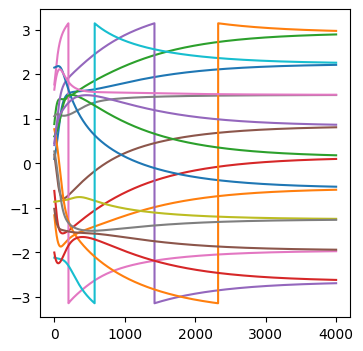

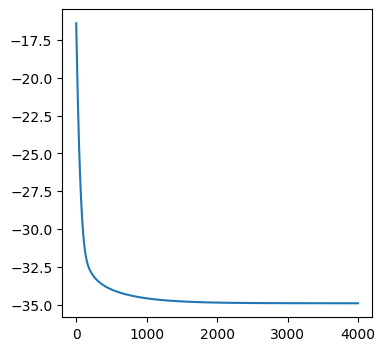

Loss at the end:  -34.913604447276406


In [66]:
n = 18
# craete a complete graph
adj = gen_cyclic_graph(n)
G = nx.from_numpy_array(adj)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)

density_original = density(adj)
print("Density of the original graph: ", density_original)
color_blocks, phi_history, curr_phi = graph_painter_basic(adj, num_iters = 4000, sigma_noise = 0.0, step_size = 0.01)
num_colors = len(color_blocks)
phi_end = phi_history[-1]
print((phi_end-np.min(phi_end))/np.pi)
color_indice_array, _ = get_color_indice_array(color_blocks, adj)
density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
print("Density of the colored graph: ", density_colored)
print("Num Colors: ", num_colors)

# Plot the graph with the coloring and phi history row wise
plt.figure(figsize=(3, 3))
nx.draw_circular(G, with_labels=True, node_color=color_indice_array)
plt.show()

plt.figure(figsize=(4,4))
plt.plot(phi_history)
# plt.legend([i for i in range(adj.shape[0])])
plt.show()


loss_list = loss(phi_history, adj)
plt.figure(figsize=(4,4))
plt.plot(loss_list)
plt.show()

print("Loss at the end: ", loss_list[-1])

/tmp/ipykernel_6593/2250983704.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Num Colors:  257
Color Adj Density:  0.8425948443579766


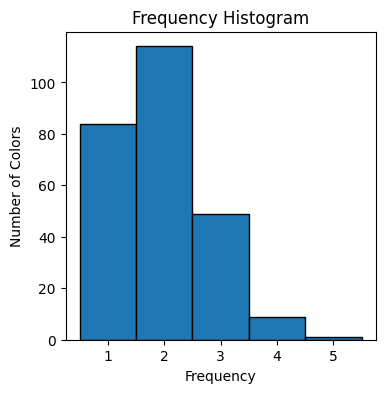

Num Colors:  251
Color Adj Density:  0.8417848605577689


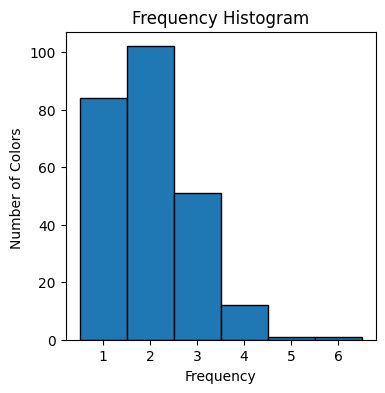

Num Colors:  227
Color Adj Density:  0.8670617129936454


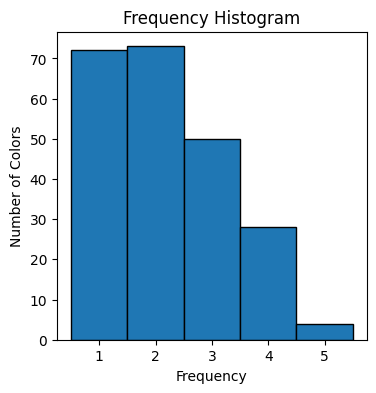

In [11]:
graph_name = 'dsjc500.5'
# graph_name = 'queen55'
G = mat_to_graph('test_graphs/'+graph_name+'.mat')
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
color_blocks_basic, phi_history_basic, _ = graph_painter_basic(adj)
color_indice_array_basic, _ = get_color_indice_array(color_blocks_basic, adj)
color_adj = get_color_adj_graph(color_indice_array_basic, adj, len(color_blocks_basic))
freq_list_basic = [len(color_blocks_basic[i]) for i in range(len(color_blocks_basic))]
# Plot histogram of the frequencies
num_colors = len(color_blocks_basic)
print("Num Colors: ", num_colors)
print("Color Adj Density: ", density(color_adj))
plt.figure(figsize=(4,4))
plt.hist(freq_list_basic, bins = np.arange(1, np.max(freq_list_basic)+2)-0.5, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Number of Colors')
plt.title('Frequency Histogram')
plt.show()

num_colors, color_blocks, phi_history = graph_painter2(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
freq_list = [len(color_blocks[i]) for i in range(len(color_blocks))]
color_indice_array, _ = get_color_indice_array(color_blocks, adj)
color_adj = get_color_adj_graph(color_indice_array, adj, num_colors)
# Plot histogram of the frequencies
print("Num Colors: ", num_colors)
print("Color Adj Density: ", density(color_adj))
plt.figure(figsize=(4,4))
plt.hist(freq_list, bins = np.arange(1, np.max(freq_list)+2)-0.5, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Number of Colors ')
plt.title('Frequency Histogram')
plt.show()

num_colors, color_blocks, phi_history = graph_painter2_scaled(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
color_indice_array, _ = get_color_indice_array(color_blocks, adj)
freq_list = [len(color_blocks[i]) for i in range(len(color_blocks))]
color_adj = get_color_adj_graph(color_indice_array, adj, num_colors)
# Plot histogram of the frequencies
print("Num Colors: ", num_colors)
print("Color Adj Density: ", density(color_adj))
plt.figure(figsize=(4,4))
plt.hist(freq_list, bins = np.arange(1, np.max(freq_list)+2)-0.5, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Number of Colors')
plt.title('Frequency Histogram')
plt.show()


/tmp/ipykernel_10591/406213974.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Graph:  dsjc125.1
Density of the graph:  0.095

Graph:  dsjc125.5
Density of the graph:  0.5021

Graph:  dsjc250.5
Density of the graph:  0.5034

Graph:  dsjc500.1
Density of the graph:  0.0999

Graph:  dsjc500.5
Density of the graph:  0.502

Graph:  dsjc500.9
Density of the graph:  0.9013



/tmp/ipykernel_10591/406213974.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num_colors_graph_artist[i], num_colors_graph_artist_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph Artist', 'Graph Artist Scaled', 'Graph Painter Basic'])


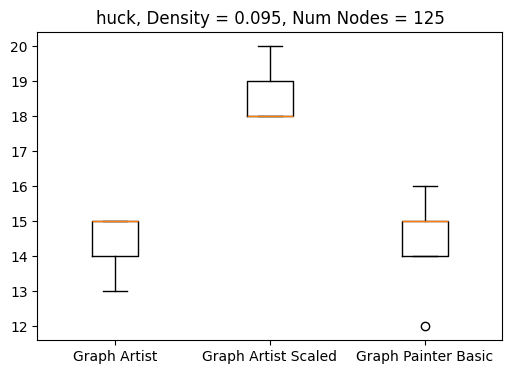

/tmp/ipykernel_10591/406213974.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num_colors_graph_artist[i], num_colors_graph_artist_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph Artist', 'Graph Artist Scaled', 'Graph Painter Basic'])


Average Random Ordering:  33.2



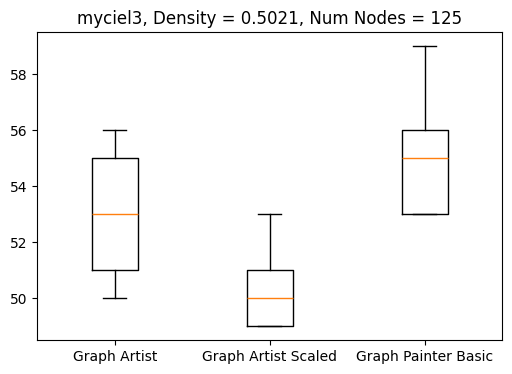

Average Random Ordering:  78.6



/tmp/ipykernel_10591/406213974.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num_colors_graph_artist[i], num_colors_graph_artist_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph Artist', 'Graph Artist Scaled', 'Graph Painter Basic'])


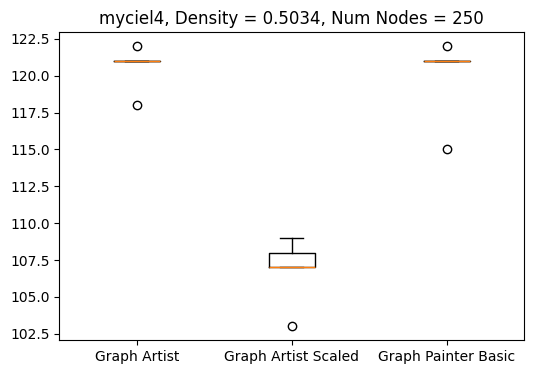

Average Random Ordering:  148.8



/tmp/ipykernel_10591/406213974.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num_colors_graph_artist[i], num_colors_graph_artist_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph Artist', 'Graph Artist Scaled', 'Graph Painter Basic'])


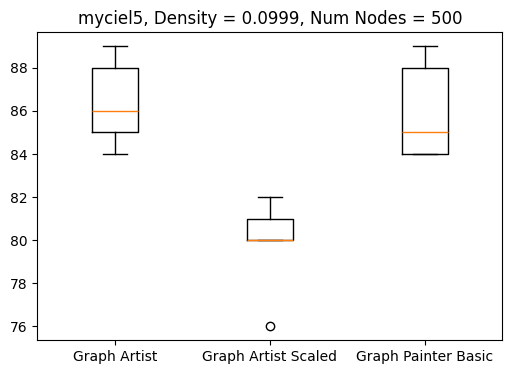

Average Random Ordering:  124.6



/tmp/ipykernel_10591/406213974.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num_colors_graph_artist[i], num_colors_graph_artist_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph Artist', 'Graph Artist Scaled', 'Graph Painter Basic'])


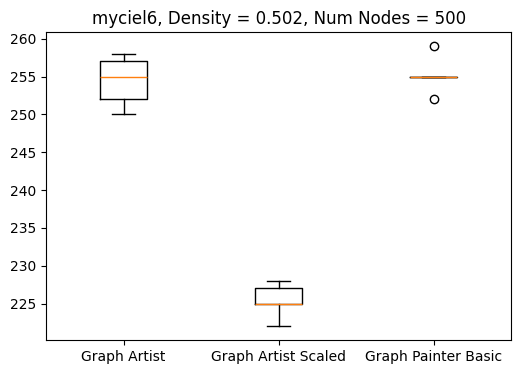

Average Random Ordering:  306.2



/tmp/ipykernel_10591/406213974.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num_colors_graph_artist[i], num_colors_graph_artist_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph Artist', 'Graph Artist Scaled', 'Graph Painter Basic'])


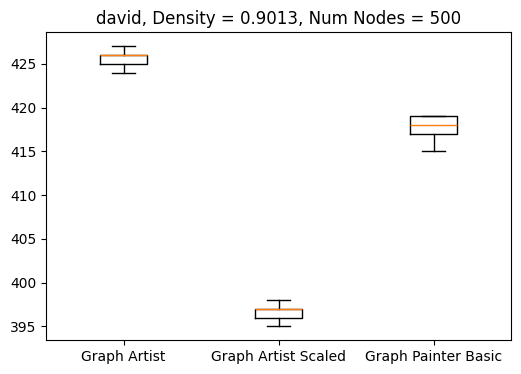

Average Random Ordering:  454.6



In [168]:
graph_names_large = ['dsjc125.1', 'dsjc125.5', 'dsjc250.5', 'dsjc500.1', 'dsjc500.5', 'dsjc500.9']
num_runs = 5
num_colors_graph_painter2 = []
num_colors_graph_painter2_scaled = []
num_colors_graph_painter_basic = []
num_colors_random_ordering = []
density_list = []
num_nodes_list = []

for graph_name in graph_names_large:
    G = mat_to_graph('test_graphs/'+graph_name+'.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    num_colors_list_graph_painter2 = []
    num_colors_list_graph_painter2_scaled = []
    num_colors_list_graph_painter_basic = []
    num_colors_list_random_ordering = []
    print("Graph: ", graph_name)
    density_temp = density(adj)
    # Trim density to 4 decimal places
    density_temp = float("{:.4f}".format
                         (density_temp))
    density_list.append(density_temp)
    num_nodes_list.append(adj.shape[0])
    print("Density of the graph: ", density_temp)
    print()
    for i in range(num_runs):
        num_colors, _, _ = graph_painter2(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
        num_colors_list_graph_painter2.append(num_colors)

        num_colors, _, _ = graph_painter2_scaled(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
        num_colors_list_graph_painter2_scaled.append(num_colors)

        color_blocks, _, _ = graph_painter_basic(adj)
        num_colors = len(color_blocks)
        num_colors_list_graph_painter_basic.append(num_colors)

        random_phases = np.random.uniform(-np.pi, np.pi, adj.shape[0])
        P, order = gen_permutation_matrix(random_phases)
        num_chr, color_blocks = get_chr(P, adj, order)
        if num_chr != len(color_blocks):
            print("ERROR IN RANDOM ORDERING")
        num_colors_list_random_ordering.append(num_chr)

    num_colors_graph_painter2.append(num_colors_list_graph_painter2)
    num_colors_graph_painter2_scaled.append(num_colors_list_graph_painter2_scaled)
    num_colors_graph_painter_basic.append(num_colors_list_graph_painter_basic)
    num_colors_random_ordering.append(num_colors_list_random_ordering)

num_colors_random_ordering = np.array(num_colors_random_ordering)
# Make a box plot for each graph with all the methods
for i in range(len(graph_names_large)):
    plt.figure(figsize=(6,4))
    plt.boxplot([num_colors_graph_painter2[i], num_colors_graph_painter2_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph painter2', 'Graph painter2 Scaled', 'Graph Painter Basic'])
    plt.title(graph_names_large[i] + ', Density = ' + str(density_list[i]) + ', Num Nodes = ' + str(num_nodes_list[i]))
    plt.show()
    print("Average Random Ordering: ", np.mean(num_colors_random_ordering[i]))
    print()

In [8]:
def check_validity(G_sub1,G_sub2,G,color_blocks1,color_blocks2,cut,part1,part2):
    colors1 = np.zeros(G_sub1.number_of_nodes())
    colors2 = np.zeros(G_sub2.number_of_nodes())
    color_index = 0
    for i,block in enumerate(color_blocks1):
        for node in block:
            colors1[node] = color_index
        color_index += 1
    for i,block in enumerate(color_blocks2):
        for node in block:
            colors2[node] = color_index
        color_index += 1

    # check if the coloring is valid
    valid_coloring1 = True
    valid_coloring2 = True
    for edges in G_sub1.edges:
        if colors1[edges[0]] == colors1[edges[1]]:
            valid_coloring1 = False
            print("Invalid coloring for subgraph 1")
            print(edges)
    for edges in G_sub2.edges:
        if colors2[edges[0]] == colors2[edges[1]]:
            valid_coloring2 = False
            print("Invalid coloring for subgraph 2")
            print(edges)

    if(valid_coloring1):
        print("Valid coloring for subgraph 1")
    if(valid_coloring2):
        print("Valid coloring for subgraph 2")

    # combine the two colorings
    # Using two pointers approach
    i = 0
    j = 0
    k = 0

    merged_colors = np.zeros(G.number_of_nodes())
    
    while i < G_sub1.number_of_nodes() and j < G_sub2.number_of_nodes():
        if cut[k] == 0:
            merged_colors[part1[i]] = colors1[i]
            i += 1
        else:
            merged_colors[part2[j]] = colors2[j]
            j += 1
        k += 1
    while i < G_sub1.number_of_nodes():
        merged_colors[part1[i]] = colors1[i]
        i += 1
        k += 1

    while j < G_sub2.number_of_nodes():
        merged_colors[part2[j]] = colors2[j]
        j += 1
        k += 1

    # check if the coloring is valid
    valid_coloring = True
    for edges in G.edges:
        if merged_colors[edges[0]] == merged_colors[edges[1]]:
            valid_coloring = False
            print("Invalid coloring for full Graph")
            print(edges)
    if valid_coloring:
        print("Valid coloring for full Graph")
    return merged_colors


def check_reducibility(num_colors, merged_colors, G):
    color_adj = np.zeros((num_colors, num_colors))
    for edges in G.edges():
        color_adj[int(merged_colors[edges[0]])][int(merged_colors[edges[1]])] = 1
        color_adj[int(merged_colors[edges[1]])][int(merged_colors[edges[0]])] = 1
    
    temp_check = np.ones((num_colors,num_colors))-np.eye(num_colors)
    flag = np.array_equal(color_adj,temp_check)
    if flag:
        print("Not reducible")
    else:
        print("Reducible")
    
    print(color_adj)
    return flag, color_adj


def min_chromatic_number(G):
    # Use networkx's greedy_color algorithm to assign colors # Might not be complete
    color_assignment = nx.coloring.greedy_color(G, strategy="largest_first")
    
    # The chromatic number is the maximum color index used + 1
    chromatic_number = max(color_assignment.values()) + 1
    
    # Returning chromatic number and color assignment for nodes
    return chromatic_number, color_assignment


In [ ]:
number_of_runs = 4
graph_coloring_min_colors = []
graph_coloring_with_MOE_cut_min_colors = []
graph_coloring_with_MOE_cut_min_colors_optimized = []
graph_coloring_with_random_cut_min_colors = []
graph_coloring_with_random_cut_min_colors_optimized = []
graph_coloring_with_goeman_williamson_min_colors = []
graph_coloring_with_goeman_williamson_min_colors_optimized = []
is_reducible_MOE = []
is_reducible_random_cut = []
is_reducible_goeman_williamson = []

for i in range (1, number_of_runs + 1):
    print("Running for", i, "th time")
    graph_name = 'dsjc125.5'
    G = mat_to_graph('test_graphs/' + graph_name + '.mat')
    
    !python GraphColoringTest.py dsjc125.5 0.01 > temp_output.txt

    min_chromatic_number_without_maxcut, color_blocks = extract_chromatic_info('temp_output.txt')
    graph_coloring_min_colors.append(min_chromatic_number_without_maxcut)
    
    # Running the MOE algorithm
    cut, cutsize = mod_one_exchange_approximation(G)
    G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    cut_sub1, cutsize_sub1 = mod_one_exchange_approximation(G_sub1)
    cut_sub2, cutsize_sub2 = mod_one_exchange_approximation(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_MOE_cut_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_MOE.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_MOE_cut_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_MOE_cut_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)



    # Running the random cut algorithm
    cutsize = 0
    while(cutsize == 0):  # We want to make sure that the subsets are non-empty
        cut, cutsize = random_cut(G)
        G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    

    cut_sub1, cutsize_sub1 = random_cut(G_sub1)
    cut_sub2, cutsize_sub2 = random_cut(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_random_cut_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_random_cut.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_random_cut_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_random_cut_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

        
    # Running the Goemans-Williamson algorithm
    cut, cutsize = gw_sdp.goemans_williamson_max_cut(G)
    G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    cut_sub1, cutsize_sub1 = gw_sdp.goemans_williamson_max_cut(G_sub1)
    cut_sub2, cutsize_sub2 = gw_sdp.goemans_williamson_max_cut(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_goeman_williamson_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_goeman_williamson.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_goeman_williamson_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_goeman_williamson_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

In [ ]:
# Making a scatter plot, one for with maxcut and one for without maxcut
# only show integer ticks on the y-axis and x-axis
plt.figure()
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors, label = 'MOE')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors, label = 'Random Cut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors, label = 'Goemans-Williamson')
plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors), 
                         min(graph_coloring_with_random_cut_min_colors), 
                         min(graph_coloring_with_goeman_williamson_min_colors))-1, 
                    max(max(graph_coloring_min_colors), 
                        max(graph_coloring_with_MOE_cut_min_colors), 
                        max(graph_coloring_with_random_cut_min_colors), 
                        max(graph_coloring_with_goeman_williamson_min_colors))+1))
plt.xlabel('Run Number')
plt.ylabel('Chromatic Number')
plt.legend()
plt.title('Chromatic Number with and without Maxcut')
plt.show()


In [ ]:
# make a scatter plot for reducibility
plt.figure()
plt.scatter(range(1, number_of_runs + 1), is_reducible_MOE, label = 'With MOE')
plt.scatter(range(1, number_of_runs + 1), is_reducible_random_cut, label = 'With Random Cut')
plt.scatter(range(1, number_of_runs + 1), is_reducible_goeman_williamson, label = 'With Goemans-Williamson')
plt.xticks(range(1, number_of_runs + 2))
plt.yticks([0,1], ['Reducible', 'Not Reducible'])
plt.xlabel('Run Number')
plt.ylabel('Reducibility')
plt.legend()
plt.title('Reducibility with and without Maxcut')
plt.show()

In [ ]:
# Making a scatter plot, one for with maxcut and one for without maxcut
# only show integer ticks on the y-axis and x-axis
plt.figure()
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors_optimized, label = 'With MOE')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors_optimized, label = 'With Random Cut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors_optimized, label = 'With Goemans-Williamson')
plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors_optimized),
                         min(graph_coloring_with_random_cut_min_colors_optimized),
                         min(graph_coloring_with_goeman_williamson_min_colors_optimized))-1,
                    max(max(graph_coloring_min_colors),
                        max(graph_coloring_with_MOE_cut_min_colors_optimized),
                        max(graph_coloring_with_random_cut_min_colors_optimized),
                        max(graph_coloring_with_goeman_williamson_min_colors_optimized))+1))

plt.xlabel('Run Number')
plt.ylabel('Chromatic Number Optimized')
plt.legend()
plt.title('Chromatic Number with and without Maxcut')
plt.show()


In [41]:
# save all the results in a dataframe
import pandas as pd
results = pd.DataFrame({'graph_coloring_min_colors': graph_coloring_min_colors,
                        'graph_coloring_with_MOE_cut_min_colors': graph_coloring_with_MOE_cut_min_colors,
                        'graph_coloring_with_random_cut_min_colors': graph_coloring_with_random_cut_min_colors,
                        'graph_coloring_with_goeman_williamson_min_colors': graph_coloring_with_goeman_williamson_min_colors,
                        'is_reducible_MOE': is_reducible_MOE,
                        'is_reducible_random_cut': is_reducible_random_cut,
                        'is_reducible_goeman_williamson': is_reducible_goeman_williamson,
                        'graph_coloring_with_MOE_cut_min_colors_optimized': graph_coloring_with_MOE_cut_min_colors_optimized,
                        'graph_coloring_with_random_cut_min_colors_optimized': graph_coloring_with_random_cut_min_colors_optimized,
                        'graph_coloring_with_goeman_williamson_min_colors_optimized': graph_coloring_with_goeman_williamson_min_colors_optimized})

# Save by the name of the graph
results.to_csv('results_' + graph_name + '.csv')


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors, label = 'MOE', marker = 'o', color = 'r')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors, label = 'Random Cut', marker = 'o', color = 'g')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors, label = 'Goemans-Williamson', marker = 'o', color = 'b')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors_optimized, label = 'MOE Optimized', marker = 'x', color = 'r')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors_optimized, label = 'Random Cut Optimized', marker = 'x', color = 'g')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors_optimized, label = 'Goemans-Williamson Optimized', marker = 'x', color = 'b')

plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors_optimized),
                         min(graph_coloring_with_random_cut_min_colors_optimized),
                         min(graph_coloring_with_goeman_williamson_min_colors_optimized))-1,
                    max(max(graph_coloring_min_colors),
                        max(graph_coloring_with_MOE_cut_min_colors_optimized),
                        max(graph_coloring_with_random_cut_min_colors_optimized),
                        max(graph_coloring_with_goeman_williamson_min_colors_optimized))+1))

plt.xlabel('Run Number')
plt.ylabel('Chromatic Number Optimized')
# show legend seperately
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Chromatic Number with and without Maxcut')
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors, graph_coloring_with_random_cut_min_colors, 
             graph_coloring_with_goeman_williamson_min_colors, graph_coloring_with_MOE_cut_min_colors_optimized, 
             graph_coloring_with_random_cut_min_colors_optimized, graph_coloring_with_goeman_williamson_min_colors_optimized])
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Without Maxcut', 'MOE', 'Random Cut', 'Goemans-Williamson',
                           'MOE Opt.', 'Random Cut Opt.', 'Goemans-Williamson Opt.'])
plt.ylabel('Chromatic Number (Both)')

plt.title('Chromatic Number with and without Maxcut')
plt.show()

In [ ]:
# Making a box plot, one for maxcut with each method and one for without maxcut

plt.figure(figsize=(10, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors_optimized, graph_coloring_with_random_cut_min_colors_optimized, graph_coloring_with_goeman_williamson_min_colors_optimized])
plt.xticks([1, 2, 3, 4], ['Without Maxcut', 'MOE Opt.', 'Random Cut Opt.', 'Goemans-Williamson Opt.'])
plt.ylabel('Chromatic Number (Optimized)')

plt.title('Chromatic Number with and without Maxcut')
plt.show()

In [ ]:
# Making a box plot, one for maxcut with each method and one for without maxcut

plt.figure(figsize=(10, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors, graph_coloring_with_random_cut_min_colors, graph_coloring_with_goeman_williamson_min_colors])
plt.xticks([1, 2, 3, 4], ['Without Maxcut', 'MOE', 'Random Cut', 'Goemans-Williamson'])
plt.ylabel('Chromatic Number')

plt.title('Chromatic Number with and without Maxcut')
plt.show()